In [61]:
import numpy as np
from PIL import Image, ImageOps
import torch
import torch.nn as nn
from scipy.stats import multivariate_normal
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.datasets import load_digits

In [62]:
#define single layers
class Linear:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.weight = torch.randn(in_channels,out_channels)
        self.bias = torch.zeros(out_channels)
        
        self.last_input = None
        self.grad_weight = None
        self.grad_bias = None
        
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x

        #fill in
        newx = ((x @ self.weight).T + self.bias.view(-1,1)).T # typical formula of the linear layer input*weights + bias
            
        return newx
    
    def backward(self, gradient):
        self.grad_weight = self.last_input.T @ gradient

        self.grad_bias = gradient.sum(0)
        
        #fill in
        newgrad = gradient @ self.weight.T
        return newgrad
    
    def update(self, learning_rate):
        self.grad_weight = torch.clamp(self.grad_weight,0,1e+10) # dont want too small or too large gradients
        self.grad_bias = torch.clamp(self.grad_bias,0,1e+10)
        self.weight = self.weight - (learning_rate * self.grad_weight)
        self.bias = self.bias - (learning_rate * self.grad_bias)

In [63]:

class ReLU:
    def __init__(self):
        self.last_input = None
    
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x
        
        newx = torch.maximum(x, torch.tensor(0)) # ReLU range is [0 to infinity]
        
        return newx
    
    def backward(self, gradient):
    
        relu_gradient = (self.last_input > 0).float() 
        newgrad = gradient * relu_gradient

        return newgrad
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass
    
############################################# no need to change anything below this line #############################################    
class Softmax:
    def __init__(self, dim=-1):
        self.last_output = None
        self.dim = dim
        
    def forward(self, x, remember=False):
        #x = torch.exp(x-torch.amax(x)) #numerical stable version -> normalize by max(x)
        x = torch.exp(x-torch.amax(x,dim=1,keepdims=True))
        if remember:
            self.last_output = x
        return x
    
    def backward(self, gradient):
        jacobian = -self.last_output[:,:,None]*self.last_output[:,None,:] #BxLxL
        #correct diagonal entries
        jacobian += torch.eye(self.last_output.size(-1)).unsqueeze(0)*self.last_output.unsqueeze(-1).repeat(1,1,self.last_output.size(-1))
        return torch.einsum("bj,bji->bi", gradient, jacobian)
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass
    
class CrossEntropyLoss:
    def __init__(self, dim=-1):
        self.last_input = None
        self.last_ground_truth = None
        self.dim = dim
    
    def forward(self, p, y):
        #convert y to one hot
        one_hot = torch.eye(p.size(-1))[y]
        self.last_input = p
        self.last_ground_truth = one_hot
        
        losses = -torch.sum(one_hot*torch.log(p), dim=-1)
        
        total_loss = torch.mean(losses)
        
        return total_loss
    
    def backward(self):
        return torch.where(self.last_ground_truth==1,-1.0/self.last_input, 0.0)
          
              
class MLP:
    def __init__(self, in_channels=2, hidden_channels=[], out_channels=2):
        self.in_channels = in_channels
        
        self.layers = []
        if len(hidden_channels)==0:
            self.layers.append(Linear(in_channels, out_channels))
        else:
            self.layers.append(Linear(in_channels, hidden_channels[0]))
            self.layers.append(ReLU())
            for i in range(len(hidden_channels)-1):
                self.layers.append(Linear(hidden_channels[i], hidden_channels[i+1]))
                self.layers.append(ReLU())
            self.layers.append(Linear(hidden_channels[-1], out_channels))
        self.layers.append(Softmax(dim=-1))
        
        self.criterion = CrossEntropyLoss(dim=-1)
        
    def forward(self, x, remember=False):
        for layer in self.layers:
            x = layer.forward(x, remember=remember)
        return x
    
    def backward(self): #calculate gradients
        grad = self.criterion.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self, learning_rate): #update each layer via gradient descent
        for layer in self.layers:
            layer.update(learning_rate)
    
    def training_step(self, x, y, learning_rate):
        probabilities = self.forward(x, remember=True) #store inputs for backward pass!
        loss = self.criterion.forward(probabilities, y)
        self.backward() #calculate gradients
        self.update(learning_rate) #update using gradient descent
        
        return loss
    
    ############################################# no need to change anything above this line #############################################  


In [64]:
def network_pass(Xtrain,ytrain, Xtest, ytest, model, no_train, no_test, batch_size=32, num_epochs=10, learning_rate = 5e-2):
    #HELPER FUNCTION to do the network pass separately and have cleaner code
    num_batches_train = int(np.ceil(no_train/batch_size))
    num_batches_test = int(np.ceil(no_test/batch_size))
    #train network
    losses_train = []
    losses_test = []

    for epoch in range(num_epochs):
        #reshuffle training data
        ind = np.random.permutation(len(Xtrain))
        Xtrain = Xtrain[ind]
        ytrain = ytrain[ind]
        #training pass
        for it in tqdm(range(num_batches_train)):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtrain))
            X = torch.FloatTensor(Xtrain[start:end])
            y = torch.LongTensor(ytrain[start:end])
            #fill in
            batch_loss = model.training_step(X,y,learning_rate)
            losses_train.append(batch_loss)
            
        
        #testing pass
        for it in range(num_batches_test):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtest))
            X = torch.FloatTensor(Xtest[start:end])
            y = torch.LongTensor(ytest[start:end])
            
            #forward pass for test data without remember (no gradient calculations)
            probs = model.forward(X, remember=False)
            batch_loss = model.criterion.forward(probs,y)
            losses_test.append(batch_loss)

    return losses_train, losses_test        


100%|██████████| 250/250 [00:00<00:00, 1141.29it/s]


(0.0, 1.0)

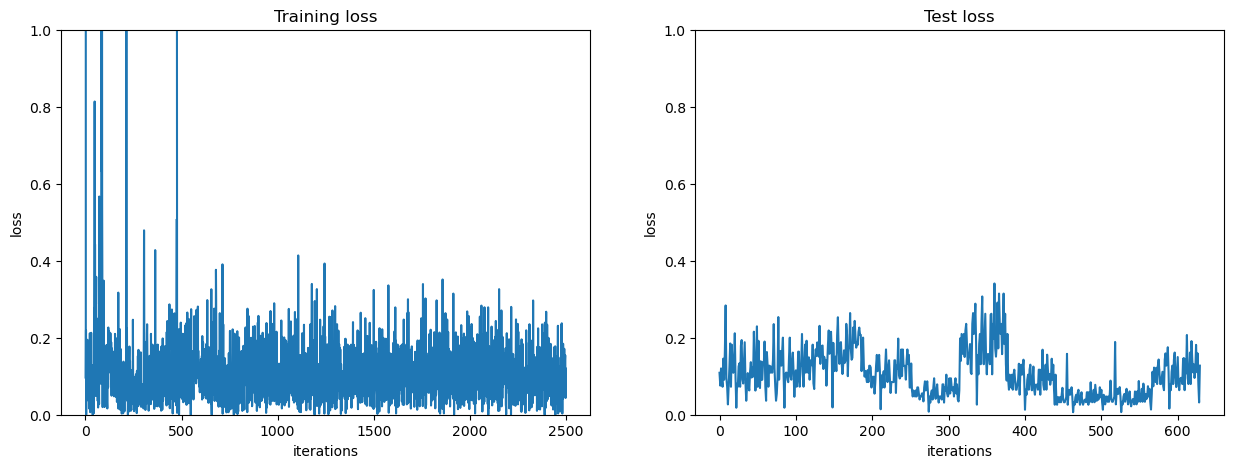

In [65]:
#training

#create datasets
Ntrain = 8000
Ntest = 2000
Xtrain, ytrain = make_moons(n_samples=Ntrain, noise=0.08, random_state=42)
Xtest, ytest = make_moons(n_samples=Ntest, noise=0.08, random_state=42)

#rescale data to [-1,1]
amin = np.amin(Xtrain, axis=0, keepdims=True)
amax = np.amax(Xtrain, axis=0, keepdims=True)

Xtrain = ((Xtrain-amin)/(amax-amin)-0.5)/0.5
Xtest = ((Xtest-amin)/(amax-amin)-0.5)/0.5

mlp = MLP(2, [30,30], 2) 
losses_train, losses_test = network_pass(Xtrain, ytrain, Xtest, ytest, model=mlp, no_train=Ntrain, no_test = Ntest)


# Plotting the data
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(np.arange(len(losses_train)), losses_train, label='Train loss')
axs[0].set_title('Training loss')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('loss')
axs[0].set_ylim([0,1])

axs[1].plot(np.arange(len(losses_test)), losses_test, label='Test loss')
axs[1].set_title('Test loss')
axs[1].set_xlabel('iterations')
axs[1].set_ylabel('loss')
axs[1].set_ylim([0,1])


# Comments regarding task 1.4

Increasing the number of hidden layers much more than the sufficient number of layers will cause accuracy in the test set to decrease. It will cause my network to overfit to the training data, so it will learn the training data, but it won't be able to generalize to new unseen data.